# COMENTARIOS:
- faixa etaria

In [ ]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.integrate import quad
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict

In [ ]:
# Importando o dataset:
from google.colab import drive
drive.mount('/content/gdrive')

df22_ = pd.read_csv('gdrive/My Drive/MICRODADOS_ENEM_2022.csv',  sep=';',encoding='iso-8859-1', usecols=["NU_ANO","TP_FAIXA_ETARIA","TP_SEXO",
                                                                                                                          "TP_COR_RACA","TP_ST_CONCLUSAO", 'TP_ANO_CONCLUIU', "TP_ESCOLA",
                                                                                                                          "NO_MUNICIPIO_PROVA","SG_UF_PROVA", "NU_NOTA_REDACAO", "NU_NOTA_COMP1", "NU_NOTA_COMP2",
                                                                                                                          "NU_NOTA_COMP3", "NU_NOTA_COMP4", "NU_NOTA_COMP5","Q001","Q002","Q003","Q004","Q005","Q006","Q022","Q025",
                                                                                                                          "NU_NOTA_LC", "NU_NOTA_CH", "NU_NOTA_MT", "NU_NOTA_CN"]).dropna()

df23 = pd.read_csv('gdrive/My Drive/MICRODADOS_ENEM_2023.csv',  sep=';',encoding='iso-8859-1', usecols=["NU_ANO","TP_FAIXA_ETARIA","TP_SEXO",
                                                                                                                          "TP_COR_RACA","TP_ST_CONCLUSAO", 'TP_ANO_CONCLUIU', "TP_ESCOLA",
                                                                                                                          "NO_MUNICIPIO_PROVA","SG_UF_PROVA", "NU_NOTA_REDACAO", "NU_NOTA_COMP1", "NU_NOTA_COMP2",
                                                                                                                          "NU_NOTA_COMP3", "NU_NOTA_COMP4", "NU_NOTA_COMP5","Q001","Q002","Q003","Q004","Q005","Q006","Q022","Q025",
                                                                                                                          "NU_NOTA_LC", "NU_NOTA_CH", "NU_NOTA_MT", "NU_NOTA_CN"]).dropna()

df21 = pd.read_csv('gdrive/My Drive/MICRODADOS_ENEM_2021.csv',  sep=';',encoding='iso-8859-1', usecols=["NU_ANO","TP_FAIXA_ETARIA","TP_SEXO",
                                                                                                                          "TP_COR_RACA","TP_ST_CONCLUSAO", 'TP_ANO_CONCLUIU', "TP_ESCOLA",
                                                                                                                          "NO_MUNICIPIO_PROVA","SG_UF_PROVA", "NU_NOTA_REDACAO", "NU_NOTA_COMP1", "NU_NOTA_COMP2",
                                                                                                                          "NU_NOTA_COMP3", "NU_NOTA_COMP4", "NU_NOTA_COMP5","Q001","Q002","Q003","Q004","Q005","Q006","Q022","Q025",
                                                                                                                          "NU_NOTA_LC", "NU_NOTA_CH", "NU_NOTA_MT", "NU_NOTA_CN"]).dropna()

df22 = pd.concat([df22_, df23, df21], ignore_index=True)


Mounted at /content/gdrive


In [ ]:
# Atualizando a coluna 'NU_ANO'
df22['NU_ANO'] = df22['NU_ANO'] - 2021

In [ ]:
# excluimos quem zerou alguma das competências da redação
df22 = df22[(df22["NU_NOTA_COMP1"] > 0) & (df22["NU_NOTA_COMP2"] > 0) & (df22["NU_NOTA_COMP3"] > 0) & (df22["NU_NOTA_COMP4"] > 0) & (df22["NU_NOTA_COMP5"] > 0)]

In [ ]:
# Masculino = 1 e Feminino = 0
df22['TP_SEXO'] = df22['TP_SEXO'].map({'F': 0, 'M': 1})


In [ ]:
# apenas quem declarou a etnia e criar dummies
df22 = df22[df22['TP_COR_RACA']!=0]

print(f'total de candidatos: {len(df22)} \n')
print(df22['TP_COR_RACA'].value_counts())

df22 = df22[df22['TP_COR_RACA']!=6]
df22 = pd.get_dummies(df22, columns=['TP_COR_RACA'], prefix='TP_COR_RACA')


total de candidatos: 6476694 

TP_COR_RACA
1    2943067
3    2658626
2     727158
4     118203
5      29638
6          2
Name: count, dtype: int64


In [ ]:
# Ao invés de usar o nome dos municipios, iremos verificar se o aluno fez a prova em uma capital
capitais = [
    'Rio Branco', 'Maceió', 'Macapá', 'Manaus', 'Salvador', 'Fortaleza',
    'Brasília', 'Vitória', 'Goiânia', 'São Luís', 'Cuiabá', 'Campo Grande',
    'Belo Horizonte', 'Belém', 'João Pessoa', 'Curitiba', 'Recife',
    'Teresina', 'Rio de Janeiro', 'Natal', 'Porto Alegre', 'Porto Velho',
    'Boa Vista', 'Florianópolis', 'São Paulo', 'Aracaju', 'Palmas'
]

df22['CAPITAL'] = df22['NO_MUNICIPIO_PROVA'].apply(lambda x: 1 if x in capitais else 0)
df22 = df22.drop('NO_MUNICIPIO_PROVA',axis=1)

In [ ]:
# proporção índios na capital é menor quando comparado com outras etnias
for i in range(1,6):
    print(f"raça cor {i}: ", df22[df22[f"TP_COR_RACA_{i}"]== True]['CAPITAL'].sum()/len(df22[df22[f"TP_COR_RACA_{i}"]== True]))

raça cor 1:  0.2982694583575569
raça cor 2:  0.3361937845695158
raça cor 3:  0.29086753834499474
raça cor 4:  0.31994957826789505
raça cor 5:  0.229064039408867


In [ ]:
# iremos usar dummies das regiões do país ao inves do nome dos estados para diminuir o numero de variaveis no modelo

regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['GO', 'MT', 'MS', 'DF'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

def mapear_regiao(uf):
    for regiao, ufs in regioes.items():
        if uf in ufs:
            return regiao
    return None
df22['Regiao'] = df22['SG_UF_PROVA'].apply(mapear_regiao)

df22 = df22.drop('SG_UF_PROVA',axis=1)
df22 = pd.get_dummies(df22, columns=['Regiao'], prefix='Regiao')

In [ ]:
# Mapeando renda familiar total a partir de Q006
faixas_salarial = {
    'A': 0,
    'B': 1212,
    'C': 1818,
    'D': 2424,
    'E': 3030,
    'F': 3636,
    'G': 4848,
    'H': 6060,
    'I': 7272,
    'J': 8484,
    'K': 9696,
    'L': 10908,
    'M': 12120,
    'N': 14544,
    'O': 18180,
    'P': 24240,
    'Q': 24241
}

# Garantir Q005 numérico
df22['Q005'] = pd.to_numeric(df22['Q005'], errors='coerce').replace(0, np.nan)

# Mapear faixa salarial e calcular diretamente a faixa de renda per capita
df22['renda_fam'] = pd.cut(
    df22['Q006'].map(faixas_salarial) / df22['Q005'],
    bins=[0, 303, 606, 909, 1212, 1818, 2424, 3030, 3636, 4848, 6060, 9090, np.inf],
    labels=list(range(12)),
    include_lowest=True
).astype('Int64')  # Int64 para suportar valores nulos de forma segura



In [ ]:
df22 = df22.drop('Q005',axis=1)
df22 = df22.drop('Q006',axis=1)

In [ ]:
# Apenas quem irá concluir o EM no ano da prova que informou o tipo de escola.

pd.crosstab(df22['TP_ST_CONCLUSAO'], df22['TP_ESCOLA'])


TP_ESCOLA,1,2,3
TP_ST_CONCLUSAO,,,
1,2788190,0,0
2,7,1947218,574647
3,1147397,0,0
4,19233,0,0


In [ ]:
# pública = 0 e privada = 1

df22 = df22[df22['TP_ST_CONCLUSAO']==2]
df22.loc[:, 'TP_ESCOLA'] = df22['TP_ESCOLA'] - 2

In [ ]:
# Excluimos quem nao sabe nem a escolaridade do pai nem da mae
df22 = df22[~((df22['Q001'] == 'H') & (df22['Q002'] == 'H'))]

# Excluimos quem nao sabe a profissão do pai nem da mae
df22 = df22[~((df22['Q003'] == 'F') & (df22['Q004'] == 'F'))]

# Aplicar a função de conversão apenas para as colunas com letras
def letra_num(letra):
    return ord(letra) - ord('A')

letra_cols = ['Q001', 'Q002', 'Q003', 'Q004', 'Q022', 'Q025']
df22[letra_cols] = df22[letra_cols].map(letra_num)

# substituimos os valores de quem não sabe para não alterar o max
df22[['Q001', 'Q002']] = df22[['Q001', 'Q002']].replace(7,-1)
df22[['Q003', 'Q004']] = df22[['Q003', 'Q004']].replace(5,-1)

# escolhemos o responsável com maior escolaridade e o com "maior emprego"
df22['maior_escolaridade'] = df22[['Q001', 'Q002']].max(axis=1)
df22['maior_emprego'] = df22[['Q003', 'Q004']].max(axis=1)

In [ ]:
print(df22.columns)

Index(['NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO',
       'Q001', 'Q002', 'Q003', 'Q004', 'Q022', 'Q025', 'TP_COR_RACA_1',
       'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4', 'TP_COR_RACA_5',
       'CAPITAL', 'Regiao_Centro-Oeste', 'Regiao_Nordeste', 'Regiao_Norte',
       'Regiao_Sudeste', 'Regiao_Sul', 'renda_fam', 'maior_escolaridade',
       'maior_emprego'],
      dtype='object')


In [ ]:
# Filtrar os dados para incluir apenas os indígenas e os não indígenas
dados_indigenas = df22[df22['TP_COR_RACA_5'] == True].copy()
dados_nao_indigenas = df22[df22['TP_COR_RACA_5'] == False].copy()

# Selecionar as colunas relevantes para o matching
colunas_relevantes = [
    'NU_ANO',
    'TP_ESCOLA', 'TP_FAIXA_ETARIA', 'Regiao_Centro-Oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste', 'Regiao_Sul',
    'Q022', 'Q025', 'renda_fam', 'maior_escolaridade', 'maior_emprego',
    'CAPITAL'
]

# Adicionar uma coluna de ID para identificar cada indígena e não indígena único
dados_indigenas['indigena_id'] = dados_indigenas.index
dados_nao_indigenas['nao_indigena_id'] = dados_nao_indigenas.index

# Agrupar por perfil socioeconômico
grupo_indigenas = dados_indigenas.groupby(colunas_relevantes)
grupo_nao_indigenas = dados_nao_indigenas.groupby(colunas_relevantes)

matches = []
nao_indigenas_usados = set()

for chave, grupo_i in grupo_indigenas:
    if chave not in grupo_nao_indigenas.groups:
        continue

    grupo_n = grupo_nao_indigenas.get_group(chave).copy()
    grupo_n = grupo_n[~grupo_n['nao_indigena_id'].isin(nao_indigenas_usados)]

    tamanho = min(len(grupo_i), len(grupo_n))
    grupo_i = grupo_i.iloc[:tamanho]
    grupo_n = grupo_n.iloc[:tamanho]

    for i, j in zip(grupo_i['indigena_id'], grupo_n['nao_indigena_id']):
        matches.append((i, j))
        nao_indigenas_usados.add(j)

print(f"Número de indígenas: {len(dados_indigenas)}")
print(f"Número de matches encontrados: {len(matches)}")


Número de indígenas: 10871
Número de matches encontrados: 10362


In [ ]:
df22= df22.drop(['Q001', 'Q002', 'Q003', 'Q004', 'Q022', 'Q025', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', "NU_NOTA_COMP2", "NU_NOTA_COMP3", "NU_NOTA_COMP5"],axis=1)
df22 = df22*1

In [ ]:
# Extrair todos os IDs envolvidos nos matches
ids_em_match = set([id for par in matches for id in par])

# Filtrar df22
df22_match = df22[df22.index.isin(ids_em_match)]

# E se quiser salvar os que não têm match
df22_sem_match = df22[~df22.index.isin(ids_em_match)]

In [ ]:
def plot_kde_por_ano(df, ano, plot=False, bw_nao_indios=0.15):
    dados_indios = df[(df['TP_COR_RACA_5'] == True) & (df['NU_ANO'] == ano)]['NU_NOTA_REDACAO']
    dados_nao_indios = df[(df['TP_COR_RACA_5'] == False) & (df['NU_ANO'] == ano)]['NU_NOTA_REDACAO']

    kde_indios = gaussian_kde(dados_indios)
    kde_nao_indios = gaussian_kde(dados_nao_indios, bw_method=bw_nao_indios)

    x_vals = np.linspace(0, 1000, 1000)
    kde_indios_data = kde_indios(x_vals)
    kde_nao_indios_data = kde_nao_indios(x_vals)

    kde_indios_interp = interp1d(x_vals, kde_indios_data, bounds_error=False, fill_value="extrapolate")
    kde_nao_indios_interp = interp1d(x_vals, kde_nao_indios_data, bounds_error=False, fill_value="extrapolate")

    if plot == True:
      plt.figure(figsize=(7, 4))
      plt.plot(x_vals, kde_indios_data, color='blue', label='Índios')
      plt.plot(x_vals, kde_nao_indios_data, color='red', label='Não Índios')
      plt.fill_between(x_vals, kde_indios_data, alpha=0.5, color='blue')
      plt.fill_between(x_vals, kde_nao_indios_data, alpha=0.5, color='red')
      plt.title(f'KDE das Notas de Redação - {ano+2021}')
      plt.xlabel('Nota de Redação')
      plt.ylabel('Densidade')
      plt.legend()
      plt.show()

    # Função área entre curvas
    def area_between_curves(x, kde1, kde2):
        return abs(kde1(x) - kde2(x))

    diffs = kde_nao_indios_interp(x_vals) - kde_indios_interp(x_vals)
    crossing_points = x_vals[np.where(np.diff(np.sign(diffs)))[0]]

    if len(crossing_points) == 0:
        print(f'Ano {ano+2021}: No crossing points found in the range.')
        return

    # Encontrar primeiro crossing point > 400 (igual seu código)
    cont = 0
    while cont < len(crossing_points) and crossing_points[cont] < 400:
        cont += 1
    if cont == len(crossing_points):
        print(f'Ano {ano+2021}: No crossing point > 400 found.')
        return

    crossing_point = crossing_points[cont]
    print(f'Ano {ano+2021}: Crossing Point: {crossing_point:.2f}')

    area_before = quad(area_between_curves, 0, crossing_point, args=(kde_nao_indios_interp, kde_indios_interp), epsabs=1e-2, epsrel=1e-2)[0]
    area_after = quad(area_between_curves, crossing_point, 1000, args=(kde_nao_indios_interp, kde_indios_interp), epsabs=1e-2, epsrel=1e-2)[0]


    print(f'Ano {ano+2021}: Area Before: {area_before:.3f}')
    print(f'Ano {ano+2021}: Area After: {area_after:.3f}\n')


---------SEM matching---------



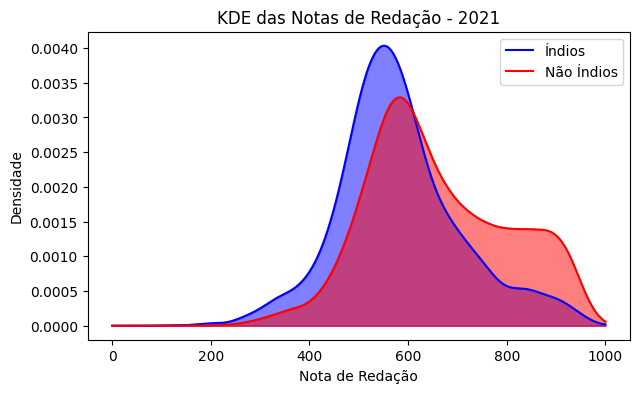

Ano 2021: Crossing Point: 609.61
Ano 2021: Area Before: 0.222
Ano 2021: Area After: 0.222



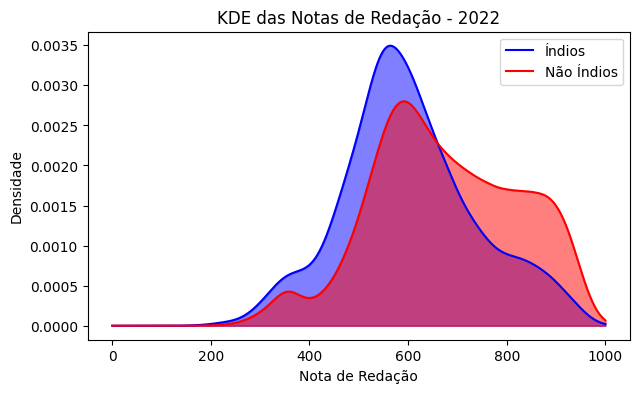

Ano 2022: Crossing Point: 659.66
Ano 2022: Area Before: 0.208
Ano 2022: Area After: 0.208



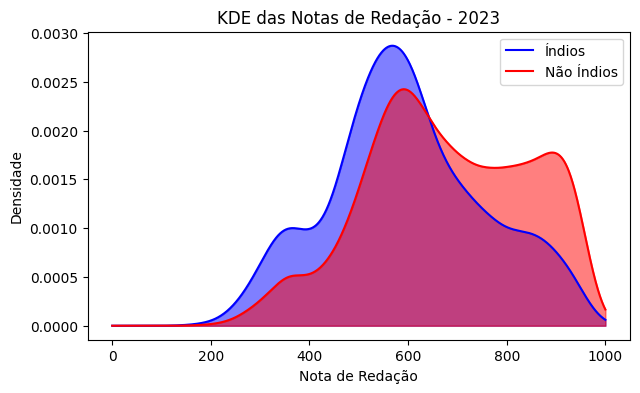

Ano 2023: Crossing Point: 641.64
Ano 2023: Area Before: 0.199
Ano 2023: Area After: 0.198

---------COM matching---------



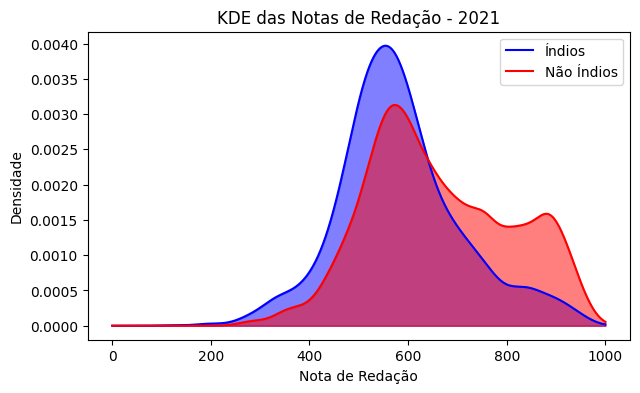

Ano 2021: Crossing Point: 639.64
Ano 2021: Area Before: 0.225
Ano 2021: Area After: 0.225



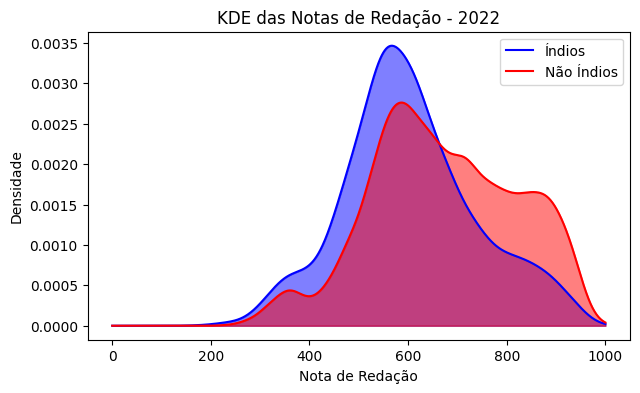

Ano 2022: Crossing Point: 662.66
Ano 2022: Area Before: 0.201
Ano 2022: Area After: 0.201



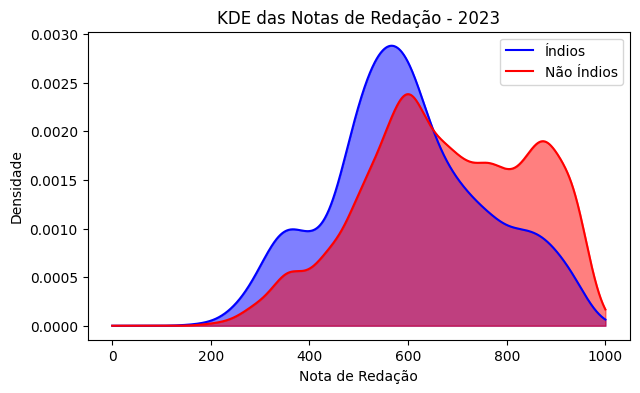

Ano 2023: Crossing Point: 650.65
Ano 2023: Area Before: 0.200
Ano 2023: Area After: 0.199



In [ ]:
# Loop para os anos desejados
print("---------SEM matching---------\n")
for ano in [0,1,2]:
    plot_kde_por_ano(df22, ano, plot = True)

# Loop para os anos desejados
print("---------COM matching---------\n")
for ano in [0,1,2]:
    plot_kde_por_ano(df22_match, ano, plot = True)


In [ ]:
def nota_grupo(dados_grupo, info, nota):
    # Definir os limites dos bins manualmente
    bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

    plt.figure(figsize=(10, 6))
    sns.histplot(dados_grupo[nota], bins=bins, kde=True, color= '#088F8F')
    plt.title(info)
    plt.xlabel('Nota de Redação')
    plt.ylabel('Frequência')
    plt.grid(False)
    plt.show()

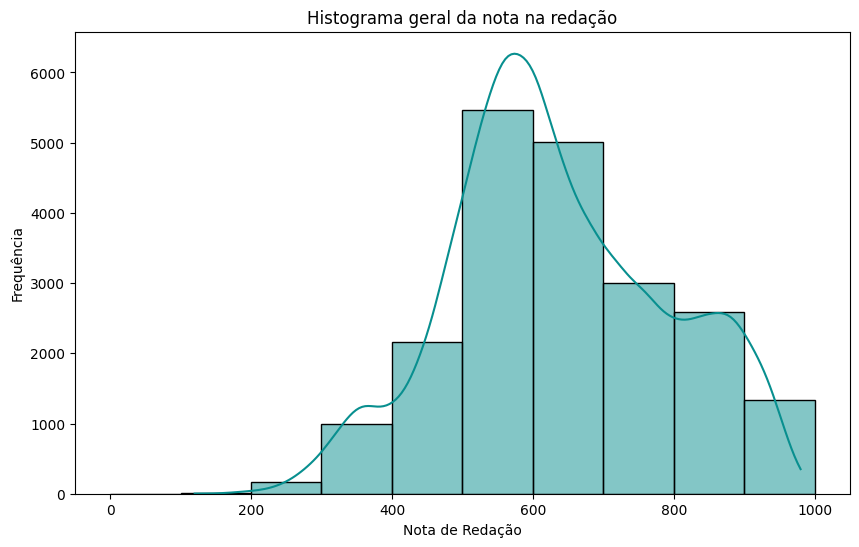

In [ ]:
nota_grupo(df22_match, 'Histograma geral da nota na redação', 'NU_NOTA_REDACAO')

In [ ]:
def nota_grupo(dados_grupo, info, nota, anos):
    bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, ano in enumerate(anos):
        sns.histplot(dados_grupo[dados_grupo['NU_ANO'] == ano][nota], bins=bins, kde=False, ax=axs[i], color= '#088F8F')
        axs[i].set_title(f'{info} {ano+2021}')
        axs[i].set_xlabel('Nota de Redação')
        axs[i].set_ylabel('Frequência')
        axs[i].grid(False)  # Remover as linhas de grade

    plt.tight_layout()
    plt.show()

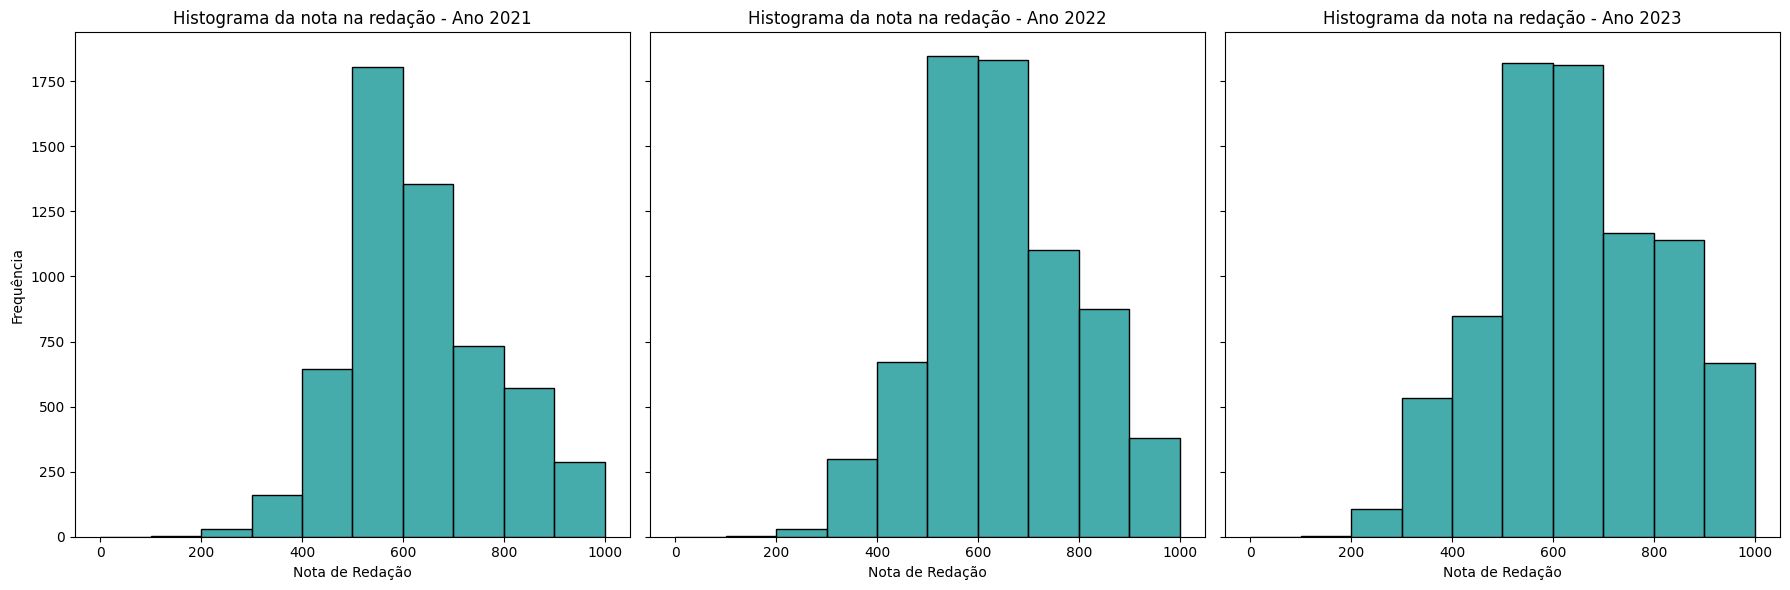

In [ ]:
anos = [0,1,2]
nota_grupo(df22_match, 'Histograma da nota na redação - Ano', 'NU_NOTA_REDACAO', anos)

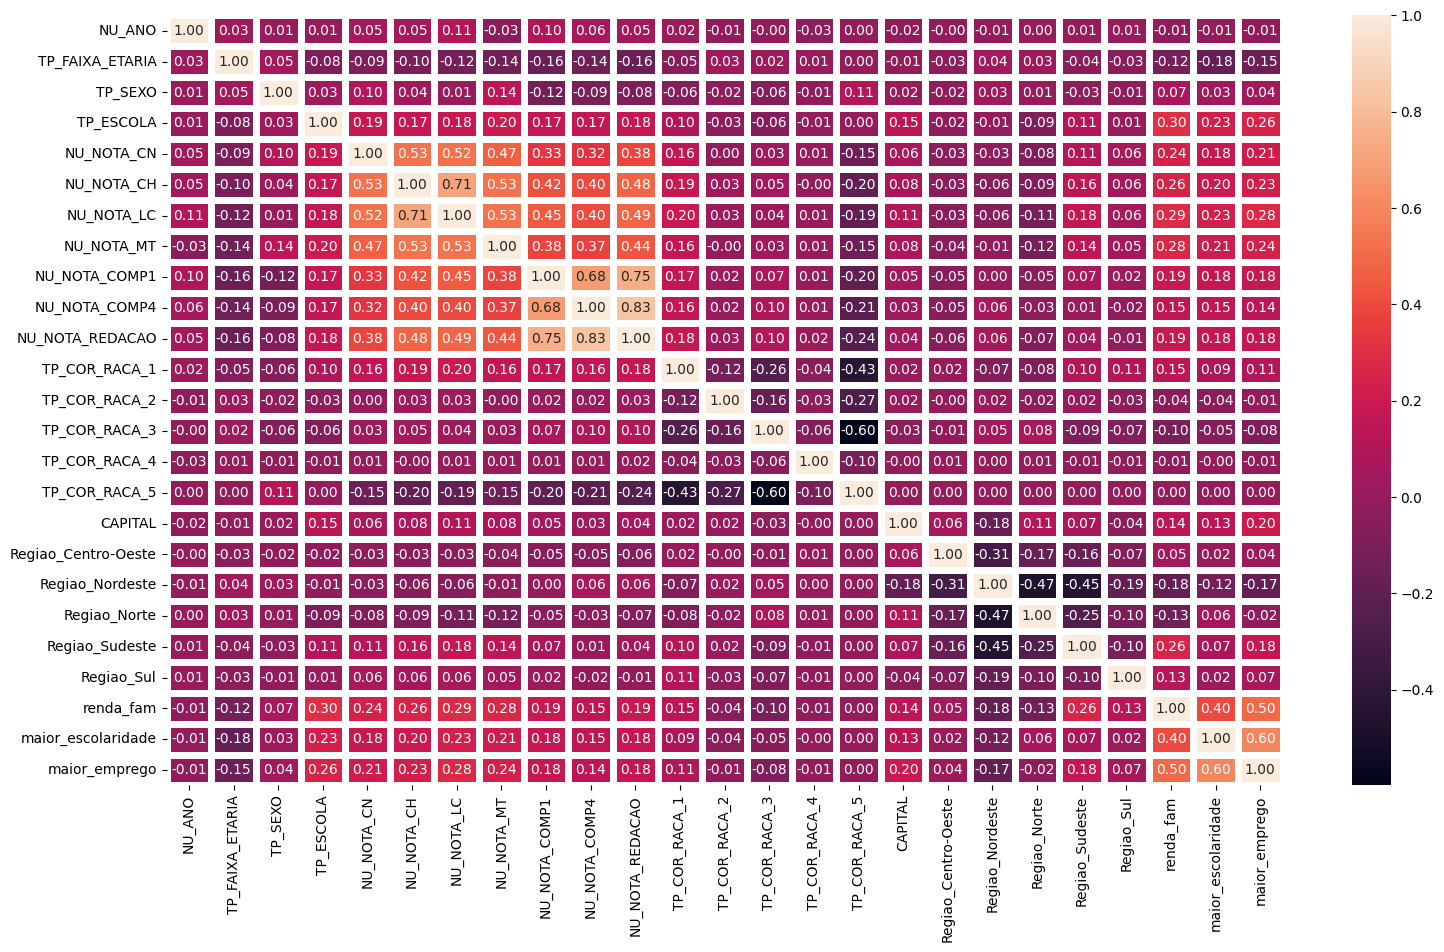

In [ ]:
plt.figure(figsize=(18, 10))
# Plot da matriz de correlação para df22_match
plot2 = sns.heatmap(df22_match.corr(method='spearman'), annot=True, fmt="0.2f", linewidths=5)
# Exibir o plot2
plt.show()